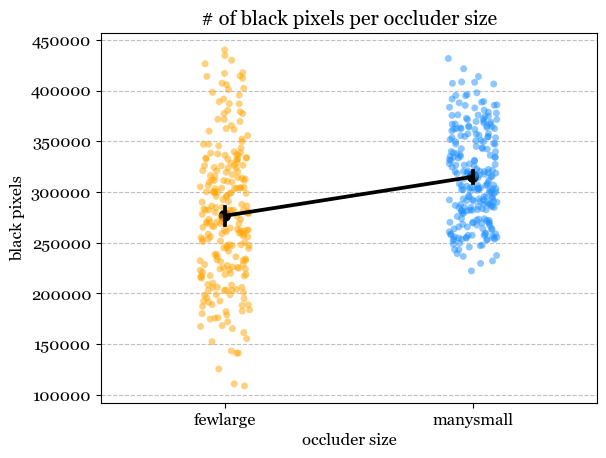

In [1]:
'''
COUNTING THE NUMBER OF BLACK PIXELS IN IMAGES
---------------------------------------------

In this script, we extract the number of black pixels present
in the stimulus images that we used in a classification task.

Our goal is to quantify the amount of black present in an image,
outside of an object that is occluded on that image.

Inputs are:
 - the occluded images
 - the original objects that were occluded

Outputs are:
 - per image, the number of black pixels
'''

import pandas as pd
import seaborn as sns
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import warnings
import pingouin as pg
warnings.filterwarnings("ignore")

plt.style.use("../Analysis/styles/mystyle.mplstyle")

# list the input images
occluded_images = glob.glob(r'../Experiment/Stimulus/all_stim/occlusion/partialviewing/*/*/*.png')
object_images = glob.glob(r'../Experiment/Stimulus/objects/*.png')

# extract the directory of the object images
object_dir = r'../Experiment/Stimulus/objects/'

# match each occluded image with its object
matched_images = pd.DataFrame({
    'occluded_images' : [i for i in occluded_images],
    'object_images' : [object_dir + i.split('/')[-1].split('_')[-1]
                       for i in occluded_images],
    'black pixels' : [(0) for x in range(len(occluded_images))], # empty column here
    'occluder size' : [i.split('partialviewing\\')[1].split('\\')[0]
                       for i in occluded_images],
})

### Calculate black pixels

# loop over all images and calculate
for i in range(len(occluded_images)): 
    # extract the name of the images
    occluded_file = matched_images['occluded_images'][i]
    object_file = matched_images['object_images'][i]

    # read the images
    occluded_im = cv.imread(occluded_file, -1)
    object_im = cv.imread(object_file, -1)

    # extract the object mask
    object_mask = object_im[:,:,3] == 255

    # remove the object from the count
    im_without_object = occluded_im[~object_mask]

    # count the black pixels
    nb_black_pixels = len(im_without_object[im_without_object == 0])

    # append the results
    matched_images['black pixels'][i] = nb_black_pixels



### Visualise the data

fig, axes = plt.subplots()

stripplot = sns.stripplot(
    data = matched_images,
    y = 'black pixels',
    x = 'occluder size',  
    palette = {'manysmall': 'dodgerBlue', 'fewlarge' : 'orange'},
    ax = axes,
    zorder = 2,
    alpha = 0.5
)
pointplot = sns.pointplot(
    data = matched_images,
    y = 'black pixels',
    x = 'occluder size',  
    ax = axes,
    join = True,
    #palette = {'manysmall': 'dodgerBlue', 'fewlarge' : 'orange'},
    color = 'black',
    #zorder = 4,
)
plt.title('# of black pixels per occluder size')

plt.show()
#plt.close()

In [2]:
df = pd.read_csv("DF_cleaned.csv")

In [3]:
object_images_names = list()
tempo = list()
for i in range(len(object_images)):
    tempo = object_images[i].split('objects\\')[1]
    object_images_names.append(tempo.split(".png")[0])

In [4]:
ms_acc = list()
fl_acc = list()
for i in range(len(object_images_names)):
    temp_df = df[df["filename"].str.contains(object_images_names[i], case=False)]
    temp_df_ms = temp_df[temp_df["size_occl"] == "many small"]
    temp_df_fl = temp_df[temp_df["size_occl"] == "few large"]

    temp_ms_acc = temp_df_ms[temp_df_ms['acc'] == True]
    temp_acc_ms = len(temp_ms_acc) / len(temp_df_ms)

    temp_fl_acc = temp_df_fl[temp_df_fl['acc'] == True]
    temp_acc_fl = len(temp_fl_acc) / len(temp_df_fl)

    ms_acc.append(temp_acc_ms)
    fl_acc.append(temp_acc_fl)



In [5]:
ms_name_list = []
fl_name_list = []
for i in range(len(ms_acc)):
    ms_name_list.append("Many Small")
for i in range(len(fl_acc)):
    fl_name_list.append("Few Large")
    
overall_acc = ms_acc + fl_acc
overall_acc_names = ms_name_list + fl_name_list

In [6]:
matched_images_ms = matched_images[matched_images['occluder size'] == "manysmall"]
matched_images_fl = matched_images[matched_images['occluder size'] == "fewlarge"]

In [7]:
pixel_per_image_ms = []
pixel_per_image_fl = []
for i in range(80):
    one = matched_images_ms["black pixels"].iloc[i]
    two = matched_images_ms["black pixels"].iloc[(i+80)]
    three = matched_images_ms["black pixels"].iloc[(i+160)]
    div = ((one + two + three) // 3)
    pixel_per_image_ms.append(div)
for i in range(80):
    one = matched_images_fl["black pixels"].iloc[i]
    two = matched_images_fl["black pixels"].iloc[(i+80)]
    three = matched_images_ms["black pixels"].iloc[(i+160)]
    div = ((one + two + three) // 3)
    pixel_per_image_fl.append(div)
pixel_per_image = pixel_per_image_ms + pixel_per_image_fl

In [8]:
image_acc = pd.DataFrame(list(zip((object_images_names*2), overall_acc, pixel_per_image, overall_acc_names)), columns = ["image","Accuracy","Pixel Count","Size"])

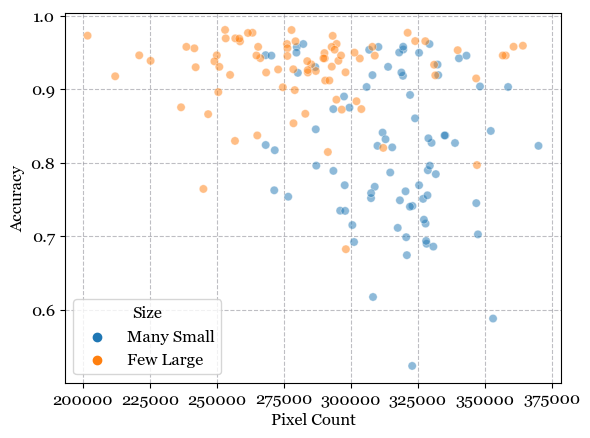

In [9]:
per_image = sns.scatterplot(
    data = image_acc,
    y = 'Accuracy',
    x = 'Pixel Count',  
    hue= "Size",
    #ax = axes,
    zorder = 2,
    alpha = 0.5)

In [11]:
pg.ttest(pixel_per_image_ms, pixel_per_image_fl, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.913882,158,two-sided,1.101039e-10,"[22516.26, 40525.39]",1.093181,7.236e+07,1.0
